In [1]:
!pip install -q torch torchvision
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
%load_ext google.colab.data_table

In [2]:
from google.colab import drive
drive.mount('/content/drive') # Outputs will be saved in your google drive

Mounted at /content/drive


In [12]:
!pip install Pillow

In [10]:
from PIL import Image

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


# Change to your new desired path
new_path = '/content/DG_Assignments-2/MNIST_VAE/'

if not os.path.exists(new_path):
    os.makedirs(new_path)



# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


In [21]:
# Necessary Hyperparameters
num_epochs = 100
learning_rate = 0.0004
batch_size = 128
latent_dim = 20 # Choose a value for the size of the latent space

# Additional Hyperparameters
beta = 3

# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x.round() # For Bernoulli assumption
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

In [22]:
train_dat = datasets.MNIST("data/", train=True, download=True, transform=transform)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, '/content/DG_Assignments-2/image_original.png')

In [23]:
import torch
import torch.nn as nn

# Reshape module for flattening the output tensors
class Reshape1(nn.Module):
    def forward(self, x):
        # Flatten the tensor except for the batch dimension
        return x.view(x.shape[0], -1)

# Reshape module for reshaping tensors to a specific shape
class Reshape2(nn.Module):
    def __init__(self, shape):
        super(Reshape2, self).__init__()
        self.shape = shape  # Target shape for reshaping

    def forward(self, x):
        # Reshape the tensor to the specified shape
        return x.view(*self.shape)

# Variational Autoencoder (VAE) definition
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder: Convolutional layers followed by linear layers to produce mean and log variance
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            Reshape1(),
            nn.Linear(1600, 120),
            nn.ReLU(),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Linear(60, latent_dim * 2)  # Outputs both mean and log variance
        )

        # Decoder: Linear layers followed by convolutional transpose layers for reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 60),
            nn.ReLU(),
            nn.Linear(60, 120),
            nn.ReLU(),
            nn.Linear(120, 1600),
            Reshape2((-1, 64, 5, 5)),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Ensures output is in the range [0, 1]
        )

    def encode(self, x):
        # Encode input to get mean and log variance
        mean, logvar = torch.chunk(self.encoder(x), chunks=2, dim=1)
        return mean, logvar

    def reparametrize(self, mu, logvar):
        # Reparameterization trick to sample from the latent space
        std = torch.exp(0.5 * logvar) if self.training else 0
        eps = torch.randn_like(std) if self.training else 0
        return mu + eps * std

    def decode(self, z):
        # Decode the latent variable to reconstruct the input
        return self.decoder(z)

    def forward(self, x):
        # Forward pass through the entire VAE model
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Model initialization and optimizer setup
model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters is: {params}")
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


Total number of parameters is: 450531
VAE(
  (encoder): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): Reshape1()
    (7): Linear(in_features=1600, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=60, bias=True)
    (10): ReLU()
    (11): Linear(in_features=60, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=1600, bias=True)
    (5): Reshape2()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): ConvTran

In [24]:
# Import necessary libraries
import torch
import torch.nn.functional as F

# Define the loss function for a Variational Autoencoder (VAE)
def loss_function_VAE(recon_x, x, mu, logvar, beta):
    """
    Calculate the loss for a batch of data in VAE training.

    Parameters:
    - recon_x: tensor, reconstructed inputs
    - x: tensor, original inputs
    - mu: tensor, mean from the latent space
    - logvar: tensor, log variance from the latent space
    - beta: scalar, weighting factor for KL divergence (controls the trade-off)

    Returns:
    - Total loss, reconstruction loss, KL divergence loss
    """
    # Reconstruction loss using binary cross-entropy
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss is the sum of reconstruction loss and weighted KL divergence
    return recon_loss + beta * KLD, recon_loss, beta * KLD

# Initialize lists to track losses
train_losses = []
test_losses = []

# Set model to training mode
model.train()

# Training loop
for epoch in range(num_epochs):
    # Variables to track losses for each epoch
    train_loss = 0
    train_RL = 0  # Reconstruction Loss
    train_KLD = 0  # KL Divergence Loss

    test_loss = 0
    test_RL = 0
    test_KLD = 0

    # Loop over batches of data in the training dataset
    for batch_idx, (data, _) in enumerate(loader_train):
        data = data.to(device)  # Move data to the device (CPU/GPU)
        optimizer.zero_grad()  # Clear gradients
        recon_x, mu, logvar = model(data)  # Forward pass
        # Calculate loss
        loss, recon_loss, KLD = loss_function_VAE(recon_x, data, mu, logvar, beta)
        train_loss += loss.item()
        train_RL += recon_loss.item()
        train_KLD += KLD.item()

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

        # Print log info every 250 batches
        if batch_idx % 250 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loader_train.dataset)} '
                  f'({100. * batch_idx / len(loader_train):.0f}%)]\tLoss: {loss.data / len(data):.6f}')

    # Print average loss at the end of the epoch
    print(f'Epoch: {epoch} Average loss: {train_loss / len(loader_train.dataset):.4f}\n')
    print("="*50, "\n")

    # Append training loss for the epoch
    train_losses.append((train_loss, train_RL, train_KLD))

    # Evaluate model on test dataset without updating weights
    model.eval()
    with torch.no_grad():
        for (test_data, _) in loader_test:
            test_data = test_data.to(device)
            recon_x, mu, logvar = model(test_data)
            loss, recon_loss, KLD = loss_function_VAE(recon_x, test_data, mu, logvar, beta)
            test_loss += loss.item()
            test_RL += recon_loss.item()
            test_KLD += KLD.item()

    # Append test loss for the epoch
    test_losses.append((test_loss, test_RL, test_KLD))
    model.train()  # Set model back to training mode

    # Save the model after the final epoch
    if epoch == num_epochs - 1:
        torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                       '/content/DG_Assignments-2/MNIST_VAE/VAE_model.pth')


Train Epoch: 0 [0/60000 (0%)]	Loss: 510.538361
Train Epoch: 0 [32000/60000 (53%)]	Loss: 203.777039
Epoch: 0 Average loss: 237.4390


Train Epoch: 1 [0/60000 (0%)]	Loss: 203.388855
Train Epoch: 1 [32000/60000 (53%)]	Loss: 192.519318
Epoch: 1 Average loss: 190.2744


Train Epoch: 2 [0/60000 (0%)]	Loss: 177.517761
Train Epoch: 2 [32000/60000 (53%)]	Loss: 173.013596
Epoch: 2 Average loss: 174.7916


Train Epoch: 3 [0/60000 (0%)]	Loss: 161.337387
Train Epoch: 3 [32000/60000 (53%)]	Loss: 166.052582
Epoch: 3 Average loss: 164.5644


Train Epoch: 4 [0/60000 (0%)]	Loss: 153.521652
Train Epoch: 4 [32000/60000 (53%)]	Loss: 150.474899
Epoch: 4 Average loss: 154.9733


Train Epoch: 5 [0/60000 (0%)]	Loss: 148.097031
Train Epoch: 5 [32000/60000 (53%)]	Loss: 146.926788
Epoch: 5 Average loss: 148.1573


Train Epoch: 6 [0/60000 (0%)]	Loss: 145.524002
Train Epoch: 6 [32000/60000 (53%)]	Loss: 145.622345
Epoch: 6 Average loss: 144.2786


Train Epoch: 7 [0/60000 (0%)]	Loss: 150.808945
Train Epoch: 7 [32000/

Text(0, 0.5, 'Test Loss')

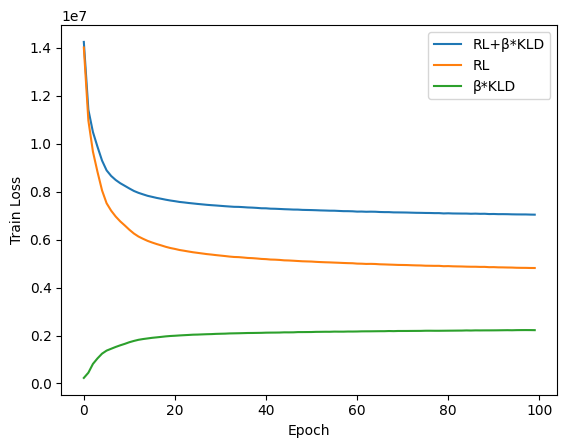

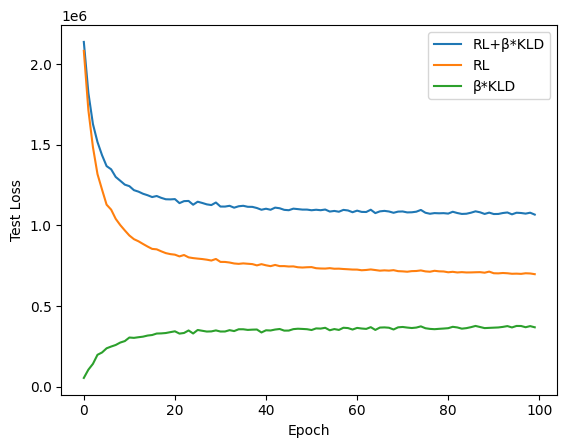

In [25]:


legend = ["RL+β*KLD","RL","β*KLD"]

plt.plot(train_losses)
plt.legend(legend)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")

plt.figure()

plt.plot(test_losses)
plt.legend(legend)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


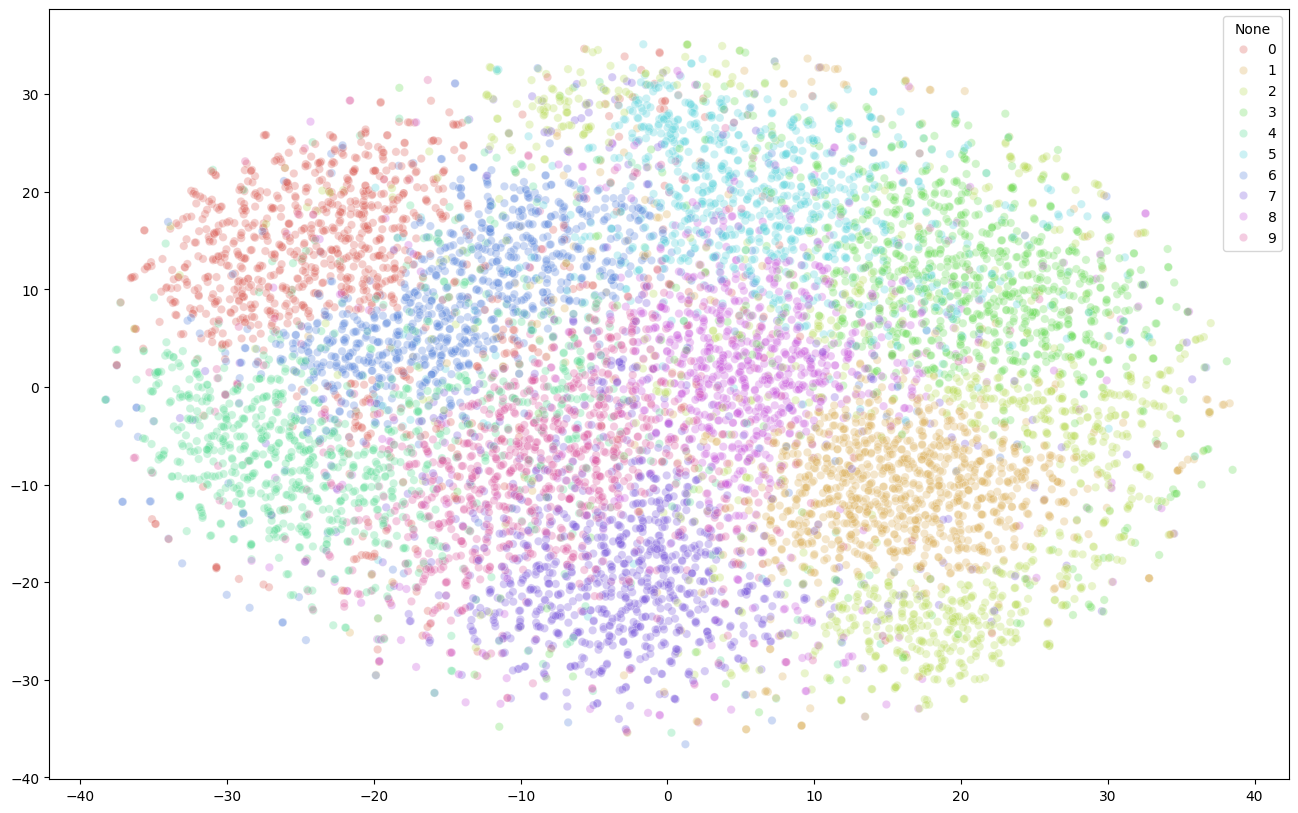

In [26]:

from sklearn.manifold import TSNE
import seaborn as sns

testing_data = ((loader_test.dataset.test_data).view(-1,1,28,28)).float()/255
labels = loader_test.dataset.test_labels

mu, logvar = model.encode(testing_data.to(device))
z = model.reparametrize(mu, logvar).cpu()

with torch.no_grad():
    tsne = TSNE(perplexity=40, n_components=2, n_iter=500, verbose=0,)
    results = tsne.fit_transform(z.detach().numpy())

    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x=results[:,0], y=results[:,1],
        alpha=0.3,
        hue=labels,
        legend="full",
        palette=sns.color_palette("hls", 10)
    )

In [27]:
# Interactive Visualization - Code Provided
test_dataloader = DataLoader(test_dat, 10000, shuffle=False)
""" Inputs to the function are
        z_embedded - X, Y positions for every point in test_dataloader
        test_dataloader - dataloader with batchsize set to 10000
        num_points - number of points plotted (will slow down with >1k)
"""
z_embedded = results
plot_tsne(z_embedded, test_dataloader, num_points=1000, darkmode=False)


alt.HConcatChart(...)

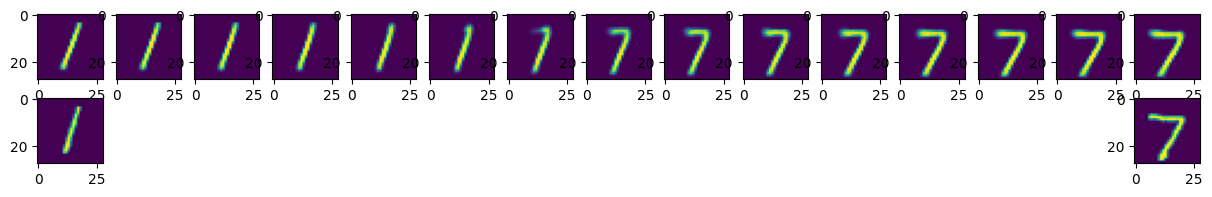

In [28]:


def interpolate(number1, number2):

    steps = 15

    N = min(torch.sum(labels == number1), torch.sum(labels == number2))

    reference = testing_data[labels == number1][:N].to(device)
    objective = testing_data[labels == number2][:N].to(device)

    mu, logvar = model.encode(reference)
    z1 = model.reparametrize(mu, logvar).cpu()

    mu, logvar = model.encode(objective)
    z2 = model.reparametrize(mu, logvar).cpu()

    embedding_values = [z2 * (i/steps) + z1 * (steps-i)/steps for i in range(steps)]
    recons = torch.stack([model.decode(embed.to(device)) for embed in embedding_values]).cpu()

    reference = reference.cpu()
    objective = objective.cpu()

    plt.figure(figsize=(steps, 2))

    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2, steps, i+1)
        plt.imshow(recon[0][0])

    plt.subplot(2, steps, steps+1)
    plt.imshow(reference[0][0])

    plt.subplot(2, steps, steps*2)
    plt.imshow(objective[0][0])

interpolate(1, 7)

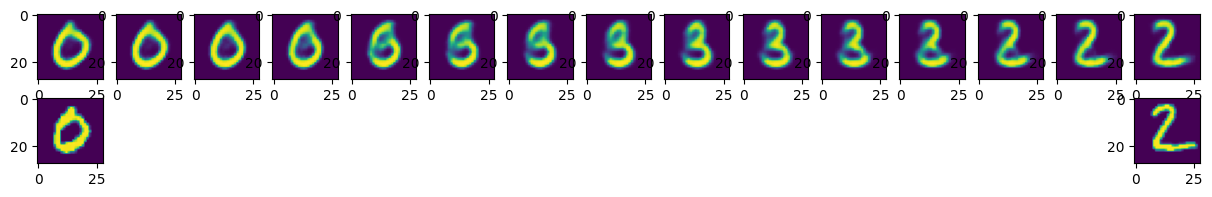

In [31]:
interpolate(0, 2)

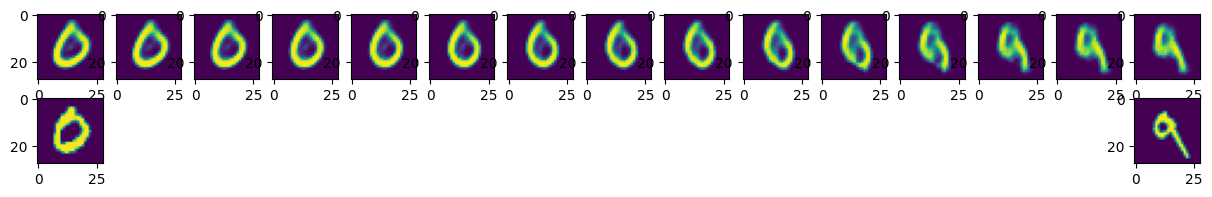

In [32]:
interpolate(0, 9)

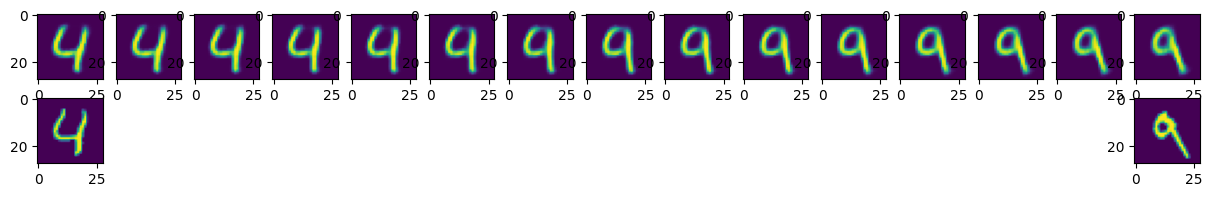

In [33]:
interpolate(4, 9)

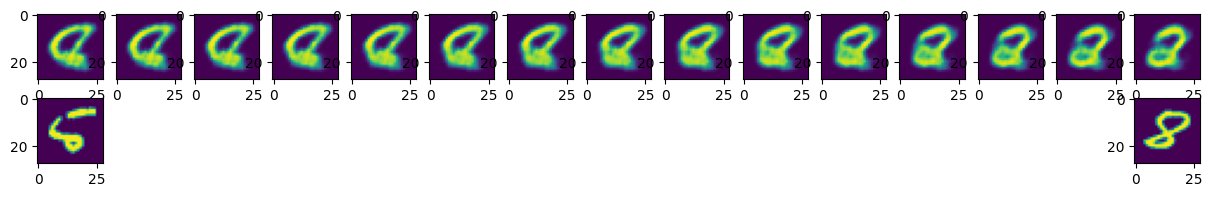

In [34]:
interpolate(5, 8)

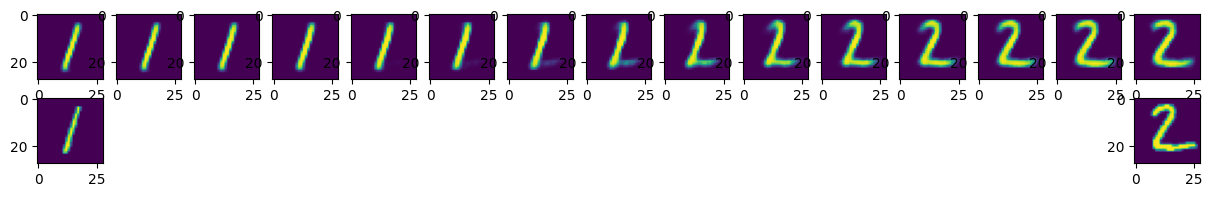

In [35]:
interpolate(1, 2)

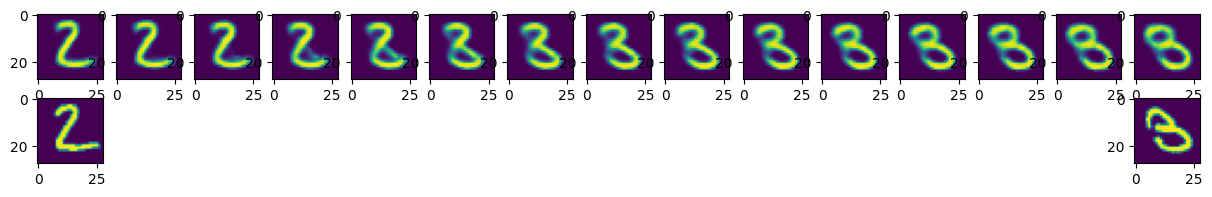

In [36]:
interpolate(2,3)

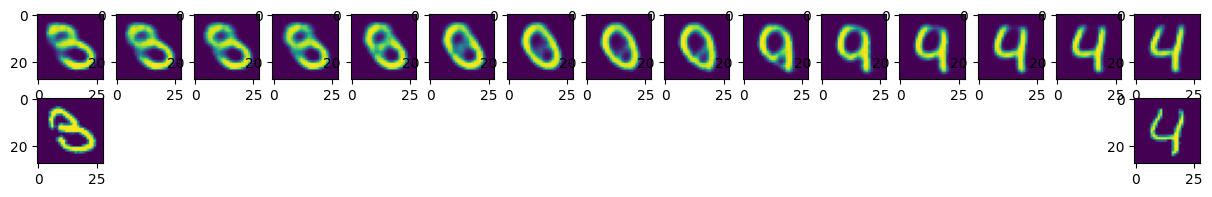

In [37]:
interpolate(3,4)

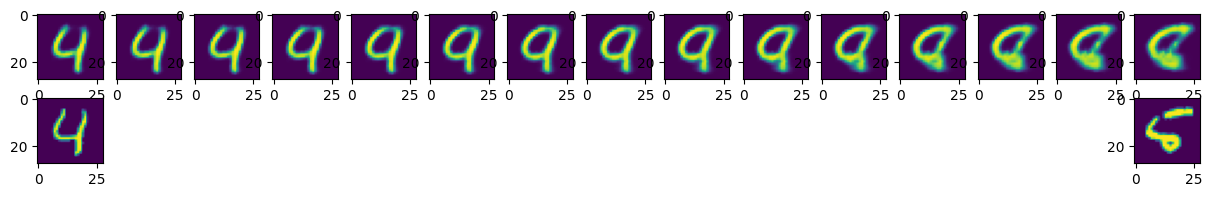

In [38]:
interpolate(4,5)

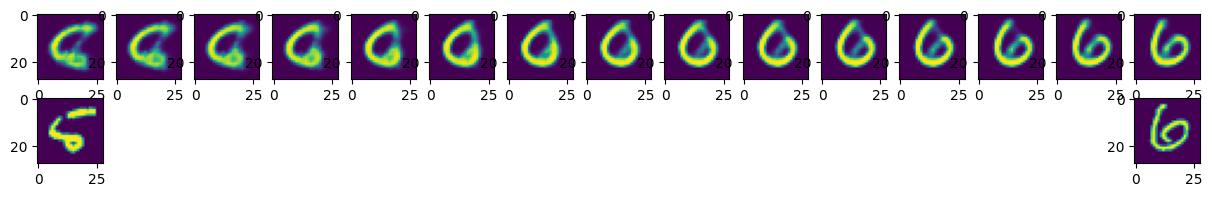

In [39]:
interpolate(5, 6)